In [ ]:
讀取每一個epoch的數據，算出數值後，對於每一輪進行平均，最後畫圖

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import re
from os import walk
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics, model_selection, feature_extraction
import math

In [48]:
# aspect setting
asp_dict = pd.read_pickle('../data/setting/aspect.pkl')    
sen_list = ['pos','neg']
sen_num = len(sen_list)

In [49]:
# read predict result 讀一個預測檔
def read_pred_result(path, fname, asp_num, sen_num):    
    E, R = re.findall(r'\d+', fname)    
    result_pair = []
    f = open((path+fname), 'r')
    for line in f:
        sp = line.split('\t')
        asp_res_list = list(map(float, sp[1:asp_num+1]))
        sen_res_list = list(map(float, sp[asp_num+1:asp_num+sen_num+1]))
        result_pair.append({"scode": int(sp[0][2:-1]), 
                            "pred_asp": asp_res_list.index(max(asp_res_list)), 
                            "pred_sen": sen_res_list.index(max(sen_res_list))})
    f.close()
    result_df = pd.DataFrame(result_pair)    
    result_df['Epoch'] = int(E)
    result_df['Round'] = int(R)    
    return result_df

In [50]:
# 讀所有的預測檔
def read_all_pred(model_ver, dataset, pdir, asp_dict, ifdoc = None):
    
    # setting
    asp_num = len(asp_dict[dataset])
    sen_num = 2
    path = f'{pdir}/{model_ver}/result_ASSA/'
    
    # read all pred from dir
    filenames = next(walk(path), (None, None, []))[2]  # [] if no file
    sum_list = list(filter(re.compile(".*sum").match, filenames)) # Read Note below    
            
    df = pd.DataFrame()    
    for fname in sum_list:   
        df_temp = read_pred_result(path, fname, asp_num, sen_num)
        df = pd.concat([df, df_temp])  
    
    # read & merge true label
    df_true = pd.read_csv(f'../data/test/test_{dataset}_sent.csv')
    if ifdoc != None:
        del df_true['sentence']
    df = df.merge(df_true, on ='scode', how = 'left')     
    
    epoch_num = df.Epoch.max()
    round_num = df.Round.max() + 1

    print(f"mver: {model_ver}")
    print(f"Epochs: {epoch_num}, Rounds: {round_num}, read {len(sum_list)} files")    
    return df

In [51]:
# 各epoch/round 單獨算aspect/sentiment
def get_eva(result_df,truecol,predcol,cate_num):
    catl = []
    alll = []
    Enum = result_df.Epoch.max()
    Rnum = result_df.Round.max() + 1
    # data of each epoch, round
    for r in range(0,Rnum):
        for e in range(1,Enum+1):
            sel = result_df[(result_df['Epoch']==e) & (result_df['Round']==r)]
            if sel.shape[0] == 0:
                break
            report = metrics.classification_report(sel[truecol], sel[predcol], output_dict=True)                        
            acc = accuracy_score(sel[truecol], sel[predcol])    
            
            catdata = [ [r,e,a] + list(report[str(a)].values()) for a in range(0, cate_num)]            
            alldata = [r,e, acc] + list(report['macro avg'].values())[:-1] + list(report['weighted avg'].values())[:-1]
            catl.append(catdata)
            alll.append(alldata)

    # as dataframe
    catl = [x for xs in catl for x in xs]
    cat_df = pd.DataFrame(catl, columns=['Round','Epoch',truecol,'precision','recall','f1-score','support'])
    all_df = pd.DataFrame(alll, columns=['Round','Epoch','accuracy','macro-precision','macro-recall','macro-f1-score','weighted-precision','weighted-recall','weighted-f1-score'])
    
    return cat_df, all_df

In [52]:
# 畫出不同list之間的差別
def plot_result_list(asp_df, sen_df, score_type, name_list, title):

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(16, 5)
    
    # left image
    for name in name_list:                
        df_sel = asp_df[asp_df['mver'] == name]
        x = df_sel['Epoch']
        axs[0].plot(x, df_sel[score_type], label = name)    
        axs[0].legend()
    axs[0].set_title('Axis [0, 0]')

    # right image
    for name in name_list:        
        df_sel = sen_df[sen_df['mver'] == name]
        x = df_sel['Epoch']
        axs[1].plot(x, df_sel[score_type], label = name)    
        axs[1].legend()
    
    axs[0].set_ylim([0.3, 0.85]) 
    axs[1].set_ylim([0.3, 0.85]) 
    axs[0].set_title(f'Aspect {score_type}', fontsize=16)
    axs[1].set_title(f'Sentiment {score_type}', fontsize=16)

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel=score_type)

    fig.suptitle(f'{title} {score_type}', fontsize=18, y=1.05)

In [53]:
# 畫出不同list之間的差別
def plot_result_cate(cat_df, cat, cat_list, score_type, name_list, title, labels=None):
    
    cat_num = len(cat_list)
    row = math.ceil(cat_num / 2)
    row_size = row * 6
    
    fig, axs = plt.subplots(row, 2)
    fig.set_size_inches(16, row_size)
    axs = axs.flatten()
    
    # left image
    for i in range(0,cat_num):
        
        df_sel = cat_df[cat_df[cat] == cat_list[i]]
        for idx, name in enumerate(name_list):
            df_mver = df_sel[df_sel['mver'] == name]
            x = df_mver['Epoch']

            if labels == None:
                axs[i].plot(x, df_mver[score_type], label = name)    
                axs[i].legend()
            else:            
                axs[i].plot(x, df_mver[score_type], label = labels[idx])    
                axs[i].legend()
        
        axs[i].set_ylim([0.1, 0.85])
        axs[i].set_title('Axis [0, 0]')
        axs[i].set_title(f'{cat} {cat_list[i]} {score_type}', fontsize=16)

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel=score_type)

    fig.suptitle(f'{title} {score_type}', fontsize=18, y=0.95)

In [54]:
# 讀取某個模型的結果，並計算表現
def read_mver_result(model_ver,dataset,pdir,asp_dict):
    # read predict result 讀取某版本所有的預測結果
    result_all = read_all_pred(model_ver,dataset,pdir,asp_dict)
        
    print("result_all",result_all.shape)
    
    # static for each round, epoch 每一次的數值
    asp_df, asp_all = get_eva(result_all,'aspect','pred_asp',asp_num)
    sen_df, sen_all = get_eva(result_all,'sentiment','pred_sen',sen_num)

    # mean static 平均數值
    asp_cat_mean = asp_df.groupby(['Epoch','aspect']).mean().reset_index()
    asp_all_mean = asp_all.groupby(['Epoch']).mean().reset_index()
    sen_cat_mean = sen_df.groupby(['Epoch','sentiment']).mean().reset_index()
    sen_all_mean = sen_all.groupby(['Epoch']).mean().reset_index()

    # transfer category name 將index轉換成名字
    asp_cat_mean['aspect'] = asp_cat_mean['aspect'].map(dict(enumerate(asp_list)))
    sen_cat_mean['sentiment'] = sen_cat_mean['sentiment'].map(dict(enumerate(sen_list)))

    asp_cat_mean['mver'] = model_ver ; sen_cat_mean['mver'] = model_ver
    asp_all_mean['mver'] = model_ver ; sen_all_mean['mver'] = model_ver
    
    return asp_cat_mean, asp_all_mean, sen_cat_mean,sen_all_mean

In [55]:
# 畫出不同list之間的差別
def plot_com(df_com, score_type, name_list, title, labels = None, ymin = 0.15,ymax = 0.6):

    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)

    # left image
    for idx, name in enumerate(name_list):
        df_sel = df_com[df_com['name'] == name]
        x = df_sel['Epoch']
        
        if labels == None:
            axs.plot(x, df_sel[score_type], label = name)    
            axs.legend()
        else:            
            axs.plot(x, df_sel[score_type], label = labels[idx])    
            axs.legend()

    axs.set_ylim([0.3, 0.5])
    axs.set_title('Axis [0, 0]')
    
    axs.set(xlabel='Epoch', ylabel=score_type)

    axs.set_ylim([ymin,ymax]) 
    axs.set_title(f'{title}', fontsize=16)
    # axs.set_title(f'{score_type} of ABSA task', fontsize=16)

In [56]:
def count_aprf(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average = 'macro')
    rec = recall_score(y_test, y_pred, average = 'macro')
    f1 = f1_score(y_test, y_pred, average = 'macro')
    return acc,pre,rec,f1

# 各epoch/round 單獨算aspect/sentiment
def get_eva_both(mver,result_df,truecol,predcol):
    
    
    result_df["pred_com"] = result_df["pred_asp"].astype(str) + '_'+ result_df["pred_sen"].astype(str)
    result_df["true_com"] = result_df["aspect"].astype(str) + '_'+result_df["sentiment"].astype(str)
    
    alll = []
    Enum = result_df.Epoch.max()
    Rnum = result_df.Round.max() + 1
    
    # data of each epoch, round
    for r in range(0,Rnum):
        for e in range(1,Enum+1):            
            sel = result_df[(result_df['Epoch']==e) & (result_df['Round']==r)]
            if sel.shape[0] == 0:
                break            
            acc,pre,rec,f1 = count_aprf(sel[truecol], sel[predcol])                        
            alldata = [r,e,acc,pre,rec,f1] 
            alll.append(alldata)

    # as dataframe
    all_df = pd.DataFrame(alll, columns=['Round','Epoch','accuracy','precision','recall','f1-score'])

    # mean static 平均數值
    all_df = all_df.groupby(['Epoch']).mean().reset_index()
    all_df['name'] = mver
    
    return all_df

In [57]:
dataset = 'YELP'
domain = dataset
asp_num = len(asp_dict[dataset])
asp_list = asp_dict[dataset]
pdir = "../model_result"

print(f"{dataset}: {asp_num}, {asp_list}")

YELP: 5, ['AMB', 'DRI', 'FOD', 'LOC', 'SRV']


In [12]:
# d = pd.read_csv(f'../data/test/test_{dataset}.csv')

In [20]:
# namel = ['ASSA_REST','ASSA-GT_REST'] # YELP_JASA_w1 YELP_textGCN TGCN_0.3_v10
# namel = ['ASSA-GT_REST','ASSA_REST','baseline']

domain = 'YELP'
namel = [
            f'{domain}_TGCN_g1_s6_gen_pos_m1', # # 需要再一輪取平均        
            f'{domain}_textGCN_g1_s2_gen_pos_m1',
            f'{domain}_baseline_10', # 需要再一輪取平均
        ] 

# domain = 'AMAZON'
# namel = [   f'{domain}_TGCN_g2_s2_gen_pos_m1', # # 需要再一輪取平均        
#             f'{domain}_textGCN_g1_s5_gen_pos_m1',
#             # f'{domain}_baseline_10', # 需要再一輪取平均
#         ] 

asp_cat = pd.DataFrame(); asp_all = pd.DataFrame()
sen_cat = pd.DataFrame(); sen_all = pd.DataFrame()

for mver in namel:
    a_cat, a_all, s_cat, s_all = read_mver_result(mver,dataset,pdir,asp_dict)    
    asp_cat = pd.concat([asp_cat, a_cat])
    asp_all = pd.concat([asp_all, a_all])
    sen_cat = pd.concat([sen_cat, s_cat])
    sen_all = pd.concat([sen_all, s_all])    

mver: YELP_TGCN_g1_s6_gen_pos_m1
Epochs: 5, Rounds: 4, read 18 files
result_all (16830, 9)
mver: YELP_textGCN_g1_s2_gen_pos_m1
Epochs: 5, Rounds: 8, read 36 files
result_all (33660, 9)
mver: YELP_baseline_10
Epochs: 10, Rounds: 3, read 26 files
result_all (24310, 9)


mver: YELP_TGCN_g1_s6_gen_pos_m1
Epochs: 5, Rounds: 4, read 18 files
mver: YELP_textGCN_g1_s2_gen_pos_m1
Epochs: 5, Rounds: 8, read 36 files
mver: YELP_baseline_10
Epochs: 10, Rounds: 3, read 26 files


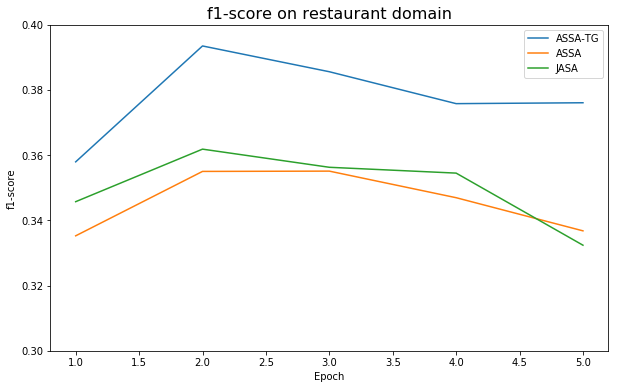

In [58]:
domain = 'YELP'
namel = [
            f'{domain}_TGCN_g1_s6_gen_pos_m1', # # 需要再一輪取平均        
            f'{domain}_textGCN_g1_s2_gen_pos_m1',
            f'{domain}_baseline_10', # 需要再一輪取平均
] 

com_eva = pd.DataFrame()
for mver in namel:
    result_com = read_all_pred(mver,domain,pdir,asp_dict)
    com_df = get_eva_both(mver,result_com,'true_com','pred_com')
    com_eva = pd.concat([com_eva,com_df])

com_eva = com_eva[com_eva['Epoch'] <= 5]

labels = ["ASSA-TG","ASSA","JASA"]
title = 'f1-score on restaurant domain'
plot_com(com_eva, 'f1-score' , namel,title ,labels, 0.3, 0.4)

plt.savefig(f'{domain}_com_f1-score.png',edgecolor='none')

In [60]:
(com_eva[com_eva['Epoch']==2]\
    [['accuracy','precision','recall','f1-score']]*100).round(2) # 'name',

,accuracy,precision,recall,f1-score
1,56.93,40.93,45.09,39.35
1,51.60,38.29,44.91,35.50
1,51.59,40.48,53.41,36.18


mver: AMAZON_TGCN_g2_s2_gen_pos_m1
Epochs: 5, Rounds: 8, read 36 files
mver: AMAZON_textGCN_g1_s5_gen_pos_m1
Epochs: 5, Rounds: 5, read 25 files
mver: AMAZON_baseline_10
Epochs: 10, Rounds: 8, read 49 files


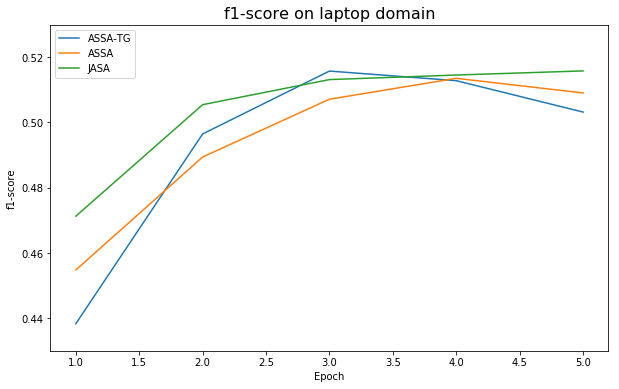

In [35]:
domain = 'AMAZON'
namel = [   f'{domain}_TGCN_g2_s2_gen_pos_m1', # # 需要再一輪取平均        
            f'{domain}_textGCN_g1_s5_gen_pos_m1',
            f'{domain}_baseline_10', # 需要再一輪取平均
        ] 

com_eva = pd.DataFrame()
for mver in namel:
    result_com = read_all_pred(mver,domain,pdir,asp_dict)
    com_df = get_eva_both(mver,result_com,'true_com','pred_com')
    com_eva = pd.concat([com_eva,com_df])
    
sel_df = com_eva[com_eva['Epoch'] <= 5]
labels = ["ASSA-TG","ASSA","JASA"]

title = 'f1-score on laptop domain'
plot_com(sel_df, 'f1-score', namel,title, labels, 0.43, 0.53)

plt.savefig(f'{domain}_com_f1-score.png',edgecolor='none')

In [38]:
sel_df[sel_df['Epoch']==3][['accuracy','precision','recall','f1-score']]

,accuracy,precision,recall,f1-score
2,0.604114,0.554977,0.520194,0.515767
2,0.588160,0.529840,0.522434,0.507136
2,0.595600,0.539979,0.525397,0.513155


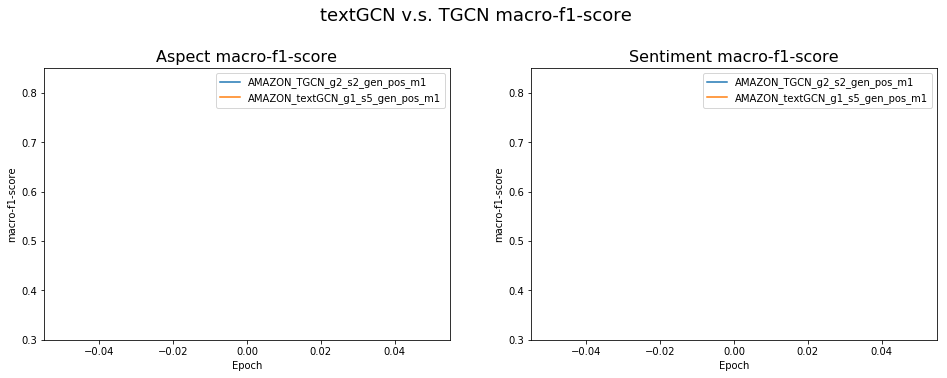

In [24]:
# 整體來看
score_type = 'macro-f1-score'
asp_all = asp_all[asp_all['Epoch'] <= 5]
sen_all = sen_all[sen_all['Epoch'] <= 5]
plot_result_list(asp_all, sen_all, score_type, namel, 'textGCN v.s. TGCN')

In [26]:
print('sentiment')
sen_all[sen_all['Epoch']==2][['mver',score_type]]

sentiment


,mver,macro-f1-score
1,YELP_TGCN_g1_s6_gen_pos_m1,0.793735
1,YELP_textGCN_g1_s2_gen_pos_m1,0.793377
1,YELP_baseline_10,0.758647


In [27]:
sen_cat = sen_cat[sen_cat['Epoch'] <= 5]


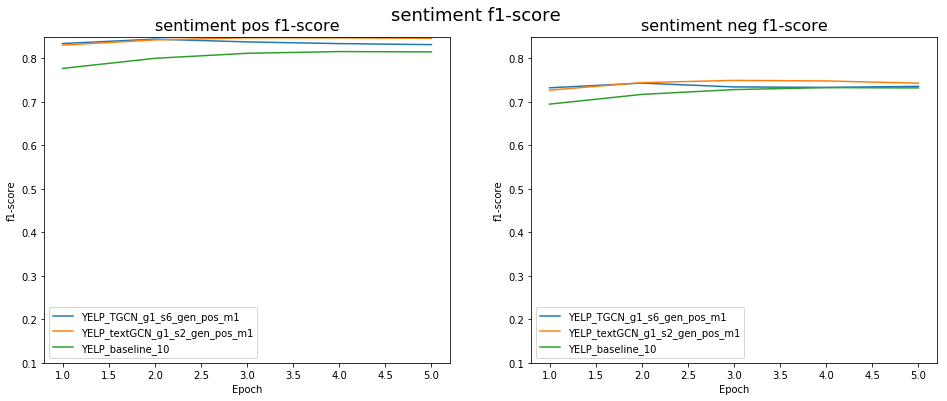

In [28]:
plot_result_cate(sen_cat, 'sentiment', sen_list, 'f1-score', namel, 'sentiment')

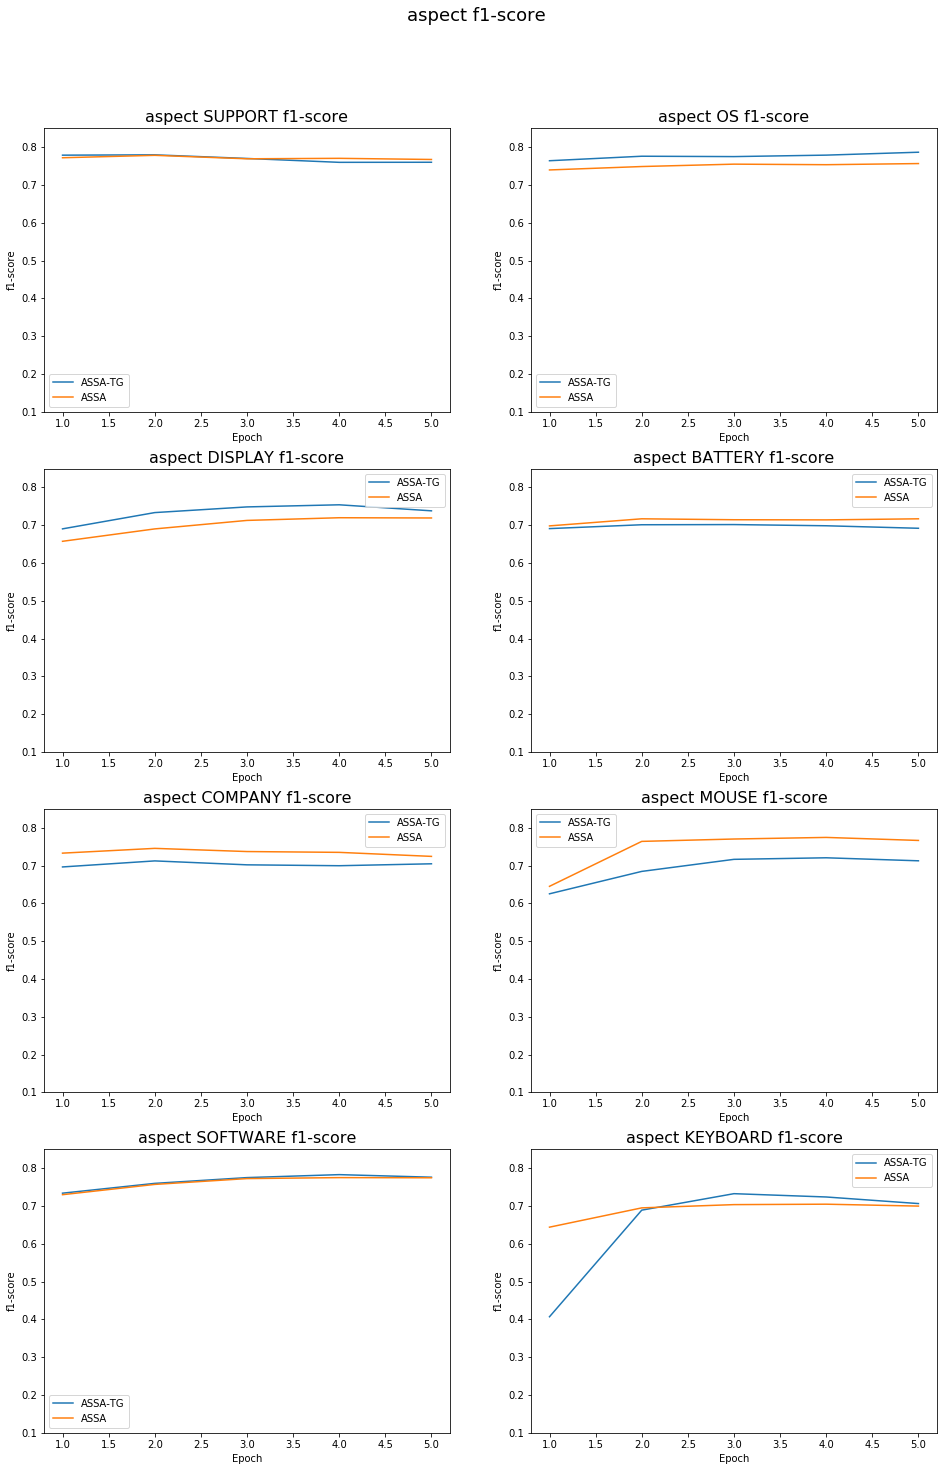

In [16]:
asp_cat = asp_cat[asp_cat['Epoch'] <= 5]

labels = ["ASSA-TG","ASSA","JASA"]
# labels = None

plot_result_cate(asp_cat, 'aspect', asp_list, 'f1-score', namel, 'aspect', labels)

plt.savefig(f'{domain}_aspect_f1-score.png',edgecolor='none')

In [32]:
asp_cat[asp_cat['Epoch'] == 2].sort_values('aspect')\
    [['mver','aspect','precision','recall','f1-score']]

,mver,aspect,precision,recall,f1-score
5,YELP_TGCN_g1_s6_gen_pos_m1,AMB,0.443260,0.587379,0.505187
5,YELP_textGCN_g1_s2_gen_pos_m1,AMB,0.540299,0.657420,0.592879
5,YELP_baseline_10,AMB,0.513476,0.676375,0.583317
6,YELP_TGCN_g1_s6_gen_pos_m1,DRI,0.443260,0.644444,0.523620
6,YELP_textGCN_g1_s2_gen_pos_m1,DRI,0.159638,0.666667,0.257388
6,YELP_baseline_10,DRI,0.223102,0.725926,0.333806
7,YELP_TGCN_g1_s6_gen_pos_m1,FOD,0.955198,0.657809,0.778985
7,YELP_textGCN_g1_s2_gen_pos_m1,FOD,0.947131,0.494267,0.649421
7,YELP_baseline_10,FOD,0.950413,0.577007,0.715088
8,YELP_TGCN_g1_s6_gen_pos_m1,LOC,0.093151,0.800000,0.166851


In [16]:
sel = asp_cat[asp_cat['mver']!='YELP_baseline_10']

In [18]:
(sel[sel['Epoch'] == 2].sort_values(['aspect','mver'])\
    [['mver','precision','recall','f1-score']]).round(2) # 'mver','aspect',

,mver,precision,recall,f1-score
5,YELP_TGCN_g1_s6_gen_pos_m1,0.44,0.59,0.51
5,YELP_textGCN_g1_s2_gen_pos_m1,0.54,0.66,0.59
6,YELP_TGCN_g1_s6_gen_pos_m1,0.44,0.64,0.52
6,YELP_textGCN_g1_s2_gen_pos_m1,0.16,0.67,0.26
7,YELP_TGCN_g1_s6_gen_pos_m1,0.96,0.66,0.78
7,YELP_textGCN_g1_s2_gen_pos_m1,0.95,0.49,0.65
8,YELP_TGCN_g1_s6_gen_pos_m1,0.09,0.80,0.17
8,YELP_textGCN_g1_s2_gen_pos_m1,0.12,0.80,0.20
9,YELP_TGCN_g1_s6_gen_pos_m1,0.86,0.79,0.82
9,YELP_textGCN_g1_s2_gen_pos_m1,0.89,0.79,0.83


#### 錯在哪個aspect

In [ ]:
model_ver = 's5_AMAZON_g1_v1'
result_all = read_all_pred(model_ver,dataset,pdir,asp_dict)

In [22]:
E = 30
R = 0
# 選取某一round的結果
select = result_all[(result_all['Epoch'] == E) & (result_all['Round'] == R)]
error_df = select.groupby(['aspect','pred_asp']).size().reset_index(name='count')
error_df = error_df.sort_values(['aspect','count'],ascending=False).groupby('aspect').head(10)
error_df['aspect'] = error_df['aspect'].map(dict(enumerate(asp_list)))
error_df['pred_asp'] = error_df['pred_asp'].map(dict(enumerate(asp_list)))
error_df = error_df.set_index(['aspect','pred_asp']).stack().to_frame()
error_df

0
aspect   pred_asp           
KEYBOARD KEYBOARD count   41
         MOUSE    count   10
         DISPLAY  count    5
         SUPPORT  count    1
         OS       count    1
         BATTERY  count    1
SOFTWARE SOFTWARE count   44
         OS       count   13
         SUPPORT  count    5
         KEYBOARD count    2
         DISPLAY  count    1
         BATTERY  count    1
         COMPANY  count    1
MOUSE    MOUSE    count   41
         SUPPORT  count    8
         SOFTWARE count    2
         KEYBOARD count    2
         OS       count    1
COMPANY  COMPANY  count   65
         OS       count    7
         SUPPORT  count    5
         KEYBOARD count    2
         DISPLAY  count    1
BATTERY  BATTERY  count   65
         SUPPORT  count    5
         DISPLAY  count    4
         SOFTWARE count    3
DISPLAY  DISPLAY  count   69
         SUPPORT  count    9
         MOUSE    count    7
         BATTERY  count    6
         SOFTWARE count    5
         COMPANY  count    3
         KEYBOARD count    1
OS       OS       count   40
         MOUSE    count    3
         SOFTWARE count    3
         SUPPORT  count    2
         DISPLAY  count    1
         KEYBOARD count    1
SUPPORT  SUPPORT  count  121
         COMPANY  count   12
         OS       count    1
         BATTERY  count    1
         MOUSE    count    1
         SOFTWARE count    1
         KEYBOARD count    1

#### 看某一次的數值

In [23]:
e = 3; r = 1
sel = result_all[(result_all['Epoch']==e) & (result_all['Round']==r)]
# print(metrics.classification_report(sel['aspect'], sel['pred_asp'])) # sentiment
print(metrics.classification_report(sel['sentiment'], sel['pred_sen'])) # aspect

              precision    recall  f1-score   support

           0       0.70      0.82      0.76       276
           1       0.84      0.72      0.78       349

   micro avg       0.77      0.77      0.77       625
   macro avg       0.77      0.77      0.77       625
weighted avg       0.78      0.77      0.77       625



#### 檢查維度

In [371]:
TRnum = result_all.Round.max() - result_all.Round.min() + 1
TEnum = result_all.Epoch.max() - result_all.Epoch.min() + 1
PNum = TRnum * TEnum
print('original')
print(f"{ PNum * asp_num}, {PNum}, { PNum * sen_num}, { PNum }")
print(asp_df.shape, asp_all.shape, sen_df.shape, sen_all.shape)

print('mean')
print(f"{ TEnum * asp_num}, {TEnum}, { TEnum * sen_num}, { TEnum }")
print(asp_cat_mean.shape, asp_all_mean.shape, sen_cat_mean.shape, sen_all_mean.shape)

original
250, 50, 100, 50
(250, 7) (50, 9) (100, 7) (50, 9)
mean
50, 10, 20, 10
(50, 7) (10, 9) (20, 7) (10, 9)


### 測試資料集裡面切出來有多少個

In [24]:
asp_name_list = asp_dict[dataset]
di = {0: asp_name_list[0], 1: asp_name_list[1], 2: asp_name_list[2],3: asp_name_list[3],4: asp_name_list[4]}

In [25]:
test = pd.read_csv(f'../data/test/test_YELP.csv')
test = test.replace({"aspect": di})

test.groupby(['aspect'])['aspect'] \
             .count() \
             .reset_index(name='count') \
             .sort_values(['count'], ascending=False)

,aspect,count
2,DISPLAY,462
1,COMPANY,312
4,SUPPORT,103
3,OS,45
0,BATTERY,15
